# Netflix Titles — Pandas EDA Case Study

## Objective
Clean and explore the Netflix titles dataset using a reproducible Pandas workflow:
- Load and inspect the dataset
- Validate schema and missing values
- Clean key columns (types, dates, text fields)
- Answer analysis questions using groupby/aggregation
- Export a cleaned dataset for reuse

Dataset: `data/raw/netflix_titles.csv`

In [29]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns",50)
pd.set_option("display.max_rows",60)

In [30]:
df = pd.read_csv("../data/raw/netflix_titles.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [31]:
df.shape,df.columns

((8807, 12),
 Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
        'release_year', 'rating', 'duration', 'listed_in', 'description'],
       dtype='str'))

In [32]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   show_id       8807 non-null   str  
 1   type          8807 non-null   str  
 2   title         8807 non-null   str  
 3   director      6173 non-null   str  
 4   cast          7982 non-null   str  
 5   country       7976 non-null   str  
 6   date_added    8797 non-null   str  
 7   release_year  8807 non-null   int64
 8   rating        8803 non-null   str  
 9   duration      8804 non-null   str  
 10  listed_in     8807 non-null   str  
 11  description   8807 non-null   str  
dtypes: int64(1), str(11)
memory usage: 825.8 KB


In [33]:
missing = (
    df.isna()
    .mean()
    .mul(100)
    .round(2)
    .sort_values(ascending=False)
    .to_frame("missing_%")
)
missing['missing_count'] = df.isna().sum()
missing

,missing_%,missing_count
director,29.91,2634
country,9.44,831
cast,9.37,825
date_added,0.11,10
rating,0.05,4
duration,0.03,3
show_id,0.00,0
type,0.00,0
title,0.00,0
release_year,0.00,0


In [34]:
df.duplicated().sum()

np.int64(0)

## Cleaning Plan (v1)

We will:
1. Standardize column names (snake_case)
2. Parse `date_added` into datetime
3. Create time features: `added_year`, `added_month`
4. Keep missing values in `director`, `cast`, `country` (do not drop rows)
5. Export a cleaned dataset to `data/processed/netflix_clean.csv`

In [35]:
df = df.copy()

df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_", regex=False)    
)

df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='str')

In [36]:
# original raw strings that failed to parse
bad_dates = df.loc[df["date_added"].notna() & pd.to_datetime(df["date_added"], errors="coerce").isna(), "date_added"]

bad_dates.head(30),bad_dates.shape

(6079        August 4, 2017
 6177     December 23, 2018
 6213     December 15, 2018
 6279          July 1, 2017
 6304         July 26, 2019
 6318          May 26, 2016
 6357      November 1, 2019
 6361      December 2, 2017
 6368        March 15, 2019
 6393       October 1, 2019
 6451     December 15, 2017
 6456          July 1, 2017
 6457        August 4, 2017
 6460         April 4, 2017
 6519     December 28, 2016
 6549        March 31, 2018
 6560      February 1, 2019
 6603       January 1, 2018
 6671          July 1, 2017
 6678     February 24, 2018
 6742        March 31, 2018
 6763     December 14, 2018
 6766         July 20, 2018
 6803      January 17, 2018
 6822     September 7, 2016
 6868      October 31, 2018
 6871       August 21, 2017
 6885       October 8, 2013
 6890      November 1, 2017
 6894      December 1, 2018
 Name: date_added, dtype: str,
 (88,))

In [37]:
# Create a raw backup column
df['date_added_raw'] = df['date_added']

# Convert from raw strings → stripped → datetime
df['date_added'] = (
    df['date_added_raw'].astype("string")
    .str.strip()
)

df['date_added'] = pd.to_datetime(df['date_added'],errors="coerce")
df['date_added'].isna().sum()

np.int64(10)

In [38]:
bad_dates = df.loc[
    df["date_added_raw"].notna() & df["date_added"].isna(),
    "date_added_raw"
]
bad_dates.head(20), bad_dates.shape
df.drop(columns=['date_added_raw'],inplace=True)

In [39]:
df['added_year'] = df['date_added'].dt.year
df['added_month'] = df['date_added'].dt.month

df[['date_added','added_year','added_month']].head()

,date_added,added_year,added_month
0,2021-09-25,2021.0,9.0
1,2021-09-24,2021.0,9.0
2,2021-09-24,2021.0,9.0
3,2021-09-24,2021.0,9.0
4,2021-09-24,2021.0,9.0


In [40]:
df.dtypes

show_id                    str
type                       str
title                      str
director                   str
cast                       str
country                    str
date_added      datetime64[us]
release_year             int64
rating                     str
duration                   str
listed_in                  str
description                str
added_year             float64
added_month            float64
dtype: object

In [41]:
df['duration'].head(10),df.duration.isna().sum()

(0       90 min
 1    2 Seasons
 2     1 Season
 3     1 Season
 4    2 Seasons
 5     1 Season
 6       91 min
 7      125 min
 8    9 Seasons
 9      104 min
 Name: duration, dtype: str,
 np.int64(3))

In [46]:
dur = df['duration'].astype("string").str.strip()

df['duration_value'] = dur.str.extract(r"(\d+)",expand=False).astype("Int64")
df['duration_unit'] = dur.str.extract(r"([A-Za-z]+)",expand=False).str.lower()

df[["type", "duration", "duration_value","duration_unit"]].head(10)

,type,duration,duration_value,duration_unit
0,Movie,90 min,90,min
1,TV Show,2 Seasons,2,seasons
2,TV Show,1 Season,1,season
3,TV Show,1 Season,1,season
4,TV Show,2 Seasons,2,seasons
5,TV Show,1 Season,1,season
6,Movie,91 min,91,min
7,Movie,125 min,125,min
8,TV Show,9 Seasons,9,seasons
9,Movie,104 min,104,min


In [48]:
# normalize unit for seasons
df["duration_unit"] = df['duration_unit'].replace({"season":"seasons"})
df["duration_unit"].value_counts(dropna=False)

duration_unit
min        6128
seasons    2676
<NA>          3
Name: count, dtype: Int64

In [54]:
# Movies should mostly be minutes
movies_unit_counts = df.loc[df['type'] == "Movie", "duration_unit"].value_counts(dropna=False)

# TV Shows should mostly be seasons
tv_unit_counts = df.loc[df['type'] == "TV Show", "duration_unit"].value_counts(dropna=False)

movies_unit_counts, tv_unit_counts

(duration_unit
 min     6128
 <NA>       3
 Name: count, dtype: Int64,
 duration_unit
 seasons    2676
 Name: count, dtype: Int64)

## Insights

We answer business-style questions using Pandas groupby/aggregation.
Each question includes:
- a table/metric
- a simple plot
- a short takeaway

In [63]:
# titles added per year
adds_by_year = (
    df.dropna(subset=["added_year"])
    .groupby("added_year")
    .size()
    .sort_index()
    .to_frame("titles_added")
)
adds_by_year.tail(5)

,titles_added
added_year,
2017.0,1188
2018.0,1649
2019.0,2016
2020.0,1879
2021.0,1498


Text(0, 0.5, 'Number of Titles')

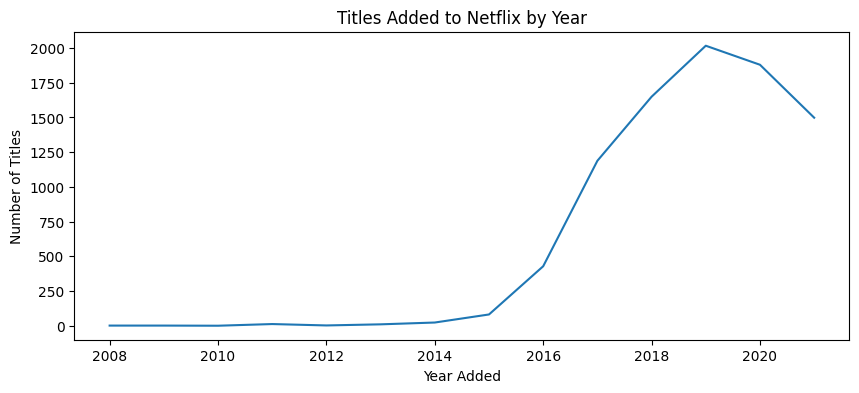

In [64]:
# plot
ax = adds_by_year.plot(kind="line", figsize=(10,4), legend=False)
ax.set_title("Titles Added to Netflix by Year")
ax.set_xlabel("Year Added")
ax.set_ylabel("Number of Titles")

**Takeaway:**  
The yearly additions show a clear trend over time, including a peak year and changes afterward.